# Stock Price Movement Prediction Using The Deutsche Börse Public Dataset & Machine Learning - Notebook 3 (Applying A Neural Network)

Here we apply the neural network approach suggested in Notebook 1 to the data set product in Notebook 2.

## Important: 20 minute by 20 minute predictions

We adapt the approaches of notebook `03-stock-price-prediction-machine-learning.ipynb` and
notebook `supporting/simple-linear-model.ipynb` to work on 20 minutes by 20 minute basis rather than on a minute by minute.

In [1]:
import pandas as pd
import numpy as np
import glob, os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from pandas import DataFrame
from pandas import concat

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15, 10) # use bigger graphs

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU
from keras.layers import LSTM
from keras import regularizers

import datetime

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We read the file we processed in the second notebook

In [2]:
input_file = '/data/cooked_v3.pkl'
df = pd.read_pickle(input_file)

Checking what stocks are available in the file

In [3]:
all_mnemonics = df.Mnemonic.unique()
df.Mnemonic.unique(), df.Mnemonic.unique().shape[0]

(array(['SNH', 'DBK', 'EOAN', 'DTE', 'CBK', 'RWE', 'IFX', 'SVAB', 'LHA',
        'DAI', 'O2D', 'TKA', 'DPW', 'HDD', 'SIE', 'AIXA', 'BAYN', 'SAP',
        'BAS', 'EVT', 'AT1', 'PSM', 'BMW', 'VOW3', 'FRE', 'GAZ', 'SDF',
        'CEC', 'ALV', 'VNA', 'B4B', 'SHA', 'AB1', 'UN01', 'DLG', 'NDX1',
        'NOA3', 'IGY', 'VODI', 'ADS', '1COV', 'TUI1', 'BPE5', 'HEI', 'KCO',
        'ADV', 'SZU', 'EVK', 'HEN3', 'WDI', 'MUV2', 'DWNI', 'MRK', 'USE',
        'PAH3', 'DEZ', 'FME', 'G1A', 'FNTN', 'RKET', 'QIA', 'DB1', 'ZAL',
        'QSC', 'CON', 'SGL', 'BVB', 'TINA', 'PBB', 'PNE3', 'RIB', 'OSR',
        'SHL', 'AOX', 'BEI', 'TEG', 'UTDI', 'ARL', 'MDG1', 'KGX', 'LXS',
        'ARO', 'TTI', 'SANT', 'GYC', 'ANO', 'LINU', 'SOW', 'SZG', 'LLD',
        'BOSS', 'BNR', 'WAF', 'LIN', 'DRI', 'NDA', 'ZIL2', 'SY1', 'CAP',
        '3W9K'], dtype=object), 100)

Next we will select the most liquid stocks from this set.

In [4]:
df['Liquidity'] = df['TradedVolume']*df['EndPrice']
tmp = df.groupby('Mnemonic')['Liquidity'].sum().to_frame()
tmp['LiquidityNormalized'] = 100.0*tmp['Liquidity']/(tmp['Liquidity'].sum())
df = df.drop(columns=['Liquidity'])

tmp.sort_values('LiquidityNormalized', ascending=False).head()

,Liquidity,LiquidityNormalized
Mnemonic,,
SIE,3.487777e+10,5.529101
DBK,3.148580e+10,4.991381
ALV,3.139013e+10,4.976214
BAYN,3.100024e+10,4.914406
VOW3,3.092967e+10,4.903217


In [5]:
most_liquid_stocks = list(tmp.sort_values('LiquidityNormalized', ascending=False).index[0:50])
print "50 Most liquid stocks:", ", ".join(most_liquid_stocks)

50 Most liquid stocks: SIE, DBK, ALV, BAYN, VOW3, DAI, SAP, BAS, DTE, BMW, ADS, CBK, EOAN, IFX, MUV2, RWE, LHA, CON, DPW, FRE, HEN3, TKA, HEI, 1COV, LINU, WDI, PSM, MRK, DB1, VNA, FME, LIN, PAH3, BEI, WAF, EVT, IGY, SDF, AIXA, OSR, SNH, DLG, KGX, LXS, DWNI, ZAL, G1A, UN01, BOSS, UTDI


Check what dates are available in the file. We will split the original set
into three parts, train, valid, test based on the dates.
If the dates are ordered chronologically, we take the first dates for the test set,
then we take the next dates for the validation set and finally we take what is
left for the test set

In [6]:
def date_part(dt):
    return str(dt).split(' ')[0]
unique_days = sorted(list(set(map(date_part , list(df.index.unique())))))
len(unique_days), unique_days[0:2], unique_days[-3:-1]

(200, ['2017-07-03', '2017-07-04'], ['2018-04-26', '2018-04-27'])

In [7]:
percent_train = 60.0
percent_valid = 5.0
percent_test = 100.0 - percent_train - percent_valid

offset_train = int(len(unique_days)*percent_train/100.0)
offset_test = offset_train + int(len(unique_days)*percent_valid/100.0)

train_valid_days = list(set(unique_days[0:offset_test]))

np.random.seed(484811945)
np.random.shuffle(train_valid_days)

train_days = train_valid_days[0:offset_train]
valid_days = train_valid_days[offset_train:]
test_days = set(unique_days[offset_test:])
'train', len(train_days), 'valid', len(valid_days), 'test', len(test_days)

('train', 120, 'valid', 10, 'test', 70)

In [8]:
df['CalcDateTime'] = df.index
df['Date'] = df['CalcDateTime'].dt.strftime("%Y-%m-%d")

In [9]:
df_train = df[df.Date.isin(list(train_days))]
df_valid = df[df.Date.isin(list(valid_days))]
df_test = df[df.Date.isin(list(test_days))]

We've prepared the train, test and valid sets. Make sure the days do not overlap

In [10]:
df_train[['CalcDateTime']].describe()

,CalcDateTime
count,8652000
unique,86520
top,2017-08-09 08:10:00
freq,100
first,2017-07-03 08:00:00
last,2018-01-09 20:00:00


In [11]:
df_valid[['CalcDateTime']].describe()

,CalcDateTime
count,721000
unique,7210
top,2017-12-29 15:53:00
freq,100
first,2017-07-05 08:00:00
last,2017-12-29 20:00:00


In [12]:
df_test[['CalcDateTime']].describe()

,CalcDateTime
count,5047000
unique,50470
top,2018-03-16 10:22:00
freq,100
first,2018-01-10 08:00:00
last,2018-04-30 20:00:00


In the class below we create features from the raw features

In [13]:
enable_non_linear_features = True

def closer_to_with_normalization(pnt, a, b, norm):
    """
    Returns the "directed" and normalized distance to the closer.
    @pnt: pnt which is compared to other two points, called a and b here
    @a: point a
    @b: point b
    @norm: normalization constant
    """    
    return (np.absolute(pnt - a) - np.absolute(pnt - b))/norm

def resample_single_stock(single_stock, interval):
    df = pd.DataFrame({
        'MaxPrice': single_stock['MaxPrice'].resample(interval).max(),
        'MinPrice': single_stock['MinPrice'].resample(interval).min(),
        'LastEndPrice': single_stock['EndPrice'].resample(interval).last(),
        'FirstStartPrice': single_stock['StartPrice'].resample(interval).first(),         
        'MeanEndPrice': single_stock['EndPrice'].resample(interval).mean(),        
        'HasTrade': single_stock['HasTrade'].resample(interval).max(),
        'Mnemonic': single_stock['Mnemonic'].resample(interval).last(),
        'Date': single_stock['Date'].resample(interval).last(),        
    })
    
    # Warning: this works because we had forward filled the prices
    df = df[df['HasTrade'] == 1.0]
    return df

def rev_pct_change(a, t):
    one_step_in_past = a
    t_steps_in_past = a.shift(t).ffill()
    return ((one_step_in_past - t_steps_in_past)/one_step_in_past).fillna(0.0)

def add_non_linear_features(main, resampled, interval):
    main['tmp:SignDirection@' + interval] = np.sign(main['x:Direction@' + interval])

    main['tmp:D1@' + interval] = np.where( 
        (main['tmp:SignDirection@' + interval] == 1.0) &
        (main['tmp:SignDirection@' + interval].shift(1) == 1.0), 1.0, 0.0)

    main['tmp:D2@' + interval] = np.where( 
        (main['tmp:SignDirection@' + interval] == -1.0) &
        (main['tmp:SignDirection@' + interval].shift(1) == -1.0), -1.0, 0.0)        

    main['x:D@' + interval] = main['tmp:D1@' + interval] + main['tmp:D2@' + interval]

    main['x:SignDirection-2@' + interval] = np.sign(
        (resampled['LastEndPrice'] - resampled['FirstStartPrice'].shift(2).ffill()
    )).fillna(0.0)

    main['tmp:D1@' + interval] = np.where( 
        (main['tmp:SignDirection@' + interval] == 1.0) &
        (main['tmp:SignDirection@' + interval].shift(1) == -1.0), main['x:SignDirection-2@' + interval], 0.0)

    main['tmp:D2@' + interval] = np.where( 
        (main['tmp:SignDirection@' + interval] == -1.0) &
        (main['tmp:SignDirection@' + interval].shift(1) == 1.0), main['x:SignDirection-2@' + interval], 0.0)        

    main['x:Da@' + interval] = main['tmp:D1@' + interval] + main['tmp:D2@' + interval]
    
    main = main.drop(columns=[
        'tmp:SignDirection@' + interval,
        'tmp:D1@' + interval,
        'tmp:D2@' + interval
    ])
        
    return main

def prepare_single_stock_multi_intervals(single_stock, predicted_price, main_interval, intervals):
        
    main = resample_single_stock(single_stock, main_interval)
    # we use the same anchor
    anchor = main['MeanEndPrice']
    future_mean_price = main[predicted_price].shift(-1)
    
    main['y(Return)'] = (future_mean_price - anchor)/anchor

    # do not normalize
    main['pseudo_y(SignReturn)'] = np.sign(main['y(Return)'])

    # actual return won't be normalized
    main['pseudo_y(pctChange)'] = (future_mean_price - anchor)/anchor
    
    # baseline will be normalized
    main['baseline'] = main['pseudo_y(pctChange)'].shift(1).fillna(0.0)    
    
    all_intervals = [main_interval] + intervals
    
    for interval in all_intervals:
        sub = resample_single_stock(single_stock, interval)
        resampled = sub.resample(main_interval).last() 

        main['x:Direction@' + interval] = \
            2.0*(resampled['LastEndPrice'] - resampled['FirstStartPrice'])/ \
            anchor

        if enable_non_linear_features:
            main = add_non_linear_features(main, resampled, interval)

        main['x:H1@' + interval] = - closer_to_with_normalization(
                                                 resampled['LastEndPrice'], 
                                                 resampled['MaxPrice'], 
                                                 resampled['MinPrice'],
                                                 anchor)    
        
        main['x:EndToMean@' + interval] = (resampled['LastEndPrice'] - resampled['MeanEndPrice'])/anchor
        
        main['x:AdjustedPctChange@' + interval] = (resampled['LastEndPrice'] - resampled['MeanEndPrice'])/resampled['MeanEndPrice']
        main['x:RevPctChange@' + interval] = rev_pct_change(resampled['LastEndPrice'], 1)
    
    main = main[main['HasTrade'] == 1.0]
    meta = main[['MeanEndPrice', 'HasTrade', 'LastEndPrice']]
    main = main.drop(columns = [
        'MaxPrice',
        'MinPrice',
        'LastEndPrice',
        'FirstStartPrice',         
        'MeanEndPrice',     
        'HasTrade'       
    ])
    return main, meta

In [14]:
class NARemover:
    def __init__(self, name):
        self.name = name
    def transform(self, single_stock):
        before = single_stock.shape[0]
        single_stock = single_stock.dropna()
        after = single_stock.shape[0]
        print("{}: Dropped {:2.2f} % of records due to NA".format(self.name, 100.0*(before - after)/(0.0001 + before)))
        return single_stock

The variable we use for predictions start with `x(`, while the variables that should be predicted start with `y(`

In [15]:
dummy = df_train[df_train.Mnemonic == 'BMW'].copy()
dummy = dummy[dummy.HasTrade == 1.0]
main_interval_dummy, intervals_dummy = '20Min', ['5Min', '10Min', '15Min']
dummy, meta = prepare_single_stock_multi_intervals(dummy, 'MeanEndPrice', main_interval_dummy, intervals_dummy)
dummy.head()

,Date,Mnemonic,y(Return),pseudo_y(SignReturn),pseudo_y(pctChange),baseline,x:Direction@20Min,x:D@20Min,x:SignDirection-2@20Min,x:Da@20Min,...,x:AdjustedPctChange@10Min,x:RevPctChange@10Min,x:Direction@15Min,x:D@15Min,x:SignDirection-2@15Min,x:Da@15Min,x:H1@15Min,x:EndToMean@15Min,x:AdjustedPctChange@15Min,x:RevPctChange@15Min
CalcDateTime,,,,,,,,,,,,,,,,,,,,,
2017-07-03 08:00:00,2017-07-03,BMW,0.002151,1.0,0.002151,0.000000,0.000488,0.0,0.0,0.0,...,0.000439,0.000000,0.004638,0.0,0.0,0.0,2.318812e-03,0.001155,0.001154,0.000000
2017-07-03 08:20:00,2017-07-03,BMW,0.001739,1.0,0.001739,0.002151,0.005845,1.0,0.0,0.0,...,0.000379,0.002919,0.003166,1.0,0.0,0.0,1.826712e-03,0.000826,0.000826,0.001581
2017-07-03 08:40:00,2017-07-03,BMW,-0.000097,-1.0,-0.000097,0.001739,0.002918,1.0,1.0,0.0,...,0.000413,0.001336,0.002431,1.0,1.0,0.0,1.215695e-03,0.000527,0.000527,0.000972
2017-07-03 09:00:00,2017-07-03,BMW,-0.000109,-1.0,-0.000109,-0.000097,-0.002918,0.0,1.0,1.0,...,-0.000012,-0.001582,0.000000,0.0,1.0,0.0,-1.727774e-16,-0.000041,-0.000041,-0.001703
2017-07-03 09:20:00,2017-07-03,BMW,0.000863,1.0,0.000863,-0.000109,0.001702,0.0,1.0,1.0,...,-0.000036,0.000851,0.001946,0.0,1.0,0.0,8.511621e-04,0.000032,0.000032,0.001094


In [16]:
class TrainingSet:
    def __init__(self, X, y, orig_df):
        self.X = X
        self.y = y
        self.baseline = orig_df['baseline'].values
        self.original_df = orig_df
        
class TrainingSetBuilder:
    def transform(self, single_stock):
        x_features = filter(lambda name: name.startswith('x(') or name.startswith('x:'), list(single_stock.dtypes.index))
        X = single_stock[x_features].values
        y = single_stock[['pseudo_y(SignReturn)']].values 
        return TrainingSet(X, y, single_stock)

In [17]:
class Predictions:
    def __init__(self, predictions, training_set):

        self.predictions = predictions
        self.training_set = training_set
        
    def evaluate(self):
        single_feature = 'baseline'
        stats_df = pd.DataFrame({
                      'predictions': self.predictions[:,0],
                      'single_feature_pred': self.training_set.original_df[single_feature].values,
                      'pseudo_y(SignReturn)': self.training_set.y[:,0],
                      'pseudo_y(pctChange)': self.training_set.original_df['pseudo_y(pctChange)'].values,
                      'y(Return)': self.training_set.original_df['y(Return)'].values})
        
        corr = stats_df. \
            corr()[['predictions', 'single_feature_pred']]. \
            iloc[1:]
            
        pred_signs = np.sign(stats_df['predictions'])
        y_signs = np.sign(stats_df['y(Return)'])
        has_answer = np.absolute(pred_signs * y_signs).sum()
        correct = np.where(pred_signs * y_signs == 1.0, 1.0, 0.0).sum()
        
        thresholds = []
        accuracy = []
        correct_lst = []
        errors = []
        percent_has_answer = []
        abs_has_answer = []
        achieved_returns = []

        preds = stats_df['predictions']
        
        for d in range(5, 46, 5):
            low = np.percentile(preds, d) 
            high = np.percentile(preds, 100 - d)
            thresholded = np.where(preds > high, 1.0, np.where(preds < low, -1.0, 0.0))
            c = np.where(np.sign(thresholded)*np.sign(y_signs) == 1.0, 1.0, 0.0).sum()
            e = np.where(np.sign(thresholded)*np.sign(y_signs) == -1.0, 1.0, 0.0).sum()
            achieved_ret = (stats_df['pseudo_y(pctChange)']*thresholded).sum()
            correct_lst.append(c)
            errors.append(e)
            accuracy.append(c/(c + e))
            percent_has_answer.append(100.0*(c + e)/pred_signs.shape[0])
            abs_has_answer.append((c + e))
            achieved_returns.append(achieved_ret)
            thresholds.append(d)
            
        at_cutoff = DataFrame({
                    'thresholds': thresholds,
                    'accuracy': accuracy,
                    'percent_with_answer': percent_has_answer,
                    'absolute_has_answer': abs_has_answer,
                    'achieved_returns': achieved_returns,
                    'correct': correct_lst,
                    'errors': errors
        })
        at_cutoff['achieved_norm_returns'] = at_cutoff['achieved_returns']/at_cutoff['absolute_has_answer']
        
        ret = stats_df['pseudo_y(pctChange)']
        rand_feature = np.where(np.random.rand(ret.shape[0]) > 0.5, 1.0, -1.0)    
        random_returns = (ret * rand_feature).sum()
        always_up_returns = (ret*1.0).sum()
        always_down_returns = (ret*-1.0).sum()
        omnicient_returns = (np.absolute(ret)).sum()
        achieved = (ret * pred_signs).sum()
        return {
            'corr': corr,
            'accuracy_at_cutoff': at_cutoff,
            'matches': {
                'percent_correct': 100*correct/has_answer,
                'percent_has_answer': has_answer/pred_signs.shape[0],
                'absolute_with_answer': has_answer,
                'size': pred_signs.shape[0]
            },
            'strategies': {
                'omniscient': omnicient_returns,
                'random': random_returns,
                'always_up': always_up_returns,
                'always_down': always_down_returns,
                'achieved': achieved,
                'num_trials': np.absolute(pred_signs).sum()
            }
        }
    
class MLModel:
    def __init__(self):
        self.model = None
        
    def fit(self, training_set, valid_set = None):
        train_X, train_y = training_set.X, training_set.y
        
        if valid_set is None:
            valid_X, valid_y = train_X, train_y
        else:
            valid_X, valid_y = valid_set.X, valid_set.y

        model = Sequential()

        model.add(Dense(10, activation='relu', input_shape =(train_X.shape[1],),
                        kernel_regularizer=regularizers.l2(0.1))) 
        model.add(Dense(5, activation='relu', kernel_regularizer=regularizers.l2(0.1)))        

        model.add(Dense(1))
        
        model.compile(loss='mean_squared_error', optimizer='adam')
        self.model = model            

        # fit network
        history = model.fit(train_X, train_y, epochs=150, batch_size=2500, validation_data=(valid_X, valid_y), verbose=2, shuffle=True)
        # plot history
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='valid')
        pyplot.legend()
        pyplot.show()
        
    def transform(self, input_set):
        predictions = self.model.predict(input_set.X)
        return Predictions(predictions, input_set)
    
    def fit_transform(self, training_set, valid_set):
        self.fit(training_set, valid_set)
        return self.transform(training_set), self.transform(valid_set)

In [18]:
def make_inverter(m, s, th):
    return lambda y: y*s + m

def make_transformer(m, s, th):
    def transform(fn):
        norm = (fn-m)/s
        return np.where(norm > th, th, np.where(norm < -th, -th, norm))
    return transform

def fit_normalize_features(prepared_single_stock):
    th = 2.5  
    inp = prepared_single_stock.copy()
    inverters = {}
    transformers = {}
    
    for f in list(inp.dtypes.index):
        if f.startswith('x(') or f.startswith('x:') or f == 'baseline':
            fn = inp[f]
            s = 0.0000001 + np.std(fn.values)
            m = np.mean(fn.values)

            inverters[f] = make_inverter(m, s, th)
            transformers[f] = make_transformer(m, s, th)
            inp[f] = transformers[f](fn)
        
    return inp, transformers, inverters

def normalize_features(prepared_single_stock, transformers):
    inp = prepared_single_stock.copy()    
    for f in list(inp.dtypes.index):
        if f.startswith('x(') or f.startswith('x:') or f == 'baseline':
            fn = inp[f]
            inp[f] = transformers[f](fn)
    return inp

In [19]:
combined_training_set = []
combined_valid_set = []
combined_test_set = []

main_interval, intervals = '20Min', ['5Min', '10Min', '15Min']
#main_interval, intervals = '4H', ['30Min', '1H', '2H']

normalizers = {}

for mnemonic in most_liquid_stocks:
    single_stock = df_train[df_train.Mnemonic == mnemonic].copy()
    single_stock = single_stock[single_stock.HasTrade == 1.0]
    single_stock, meta = prepare_single_stock_multi_intervals(single_stock, 'MeanEndPrice', main_interval, intervals)
    single_stock = NARemover(mnemonic).transform(single_stock)
    single_stock, single_stock_transformer, _ = fit_normalize_features(single_stock)
    normalizers[mnemonic] = single_stock_transformer
    
    combined_training_set.append(single_stock)
    print("train", single_stock.shape)
    
    single_stock = df_valid[df_valid.Mnemonic == mnemonic].copy()
    single_stock = single_stock[single_stock.HasTrade == 1.0] 
    single_stock, meta = prepare_single_stock_multi_intervals(single_stock, 'MeanEndPrice', main_interval, intervals)
    single_stock = NARemover(mnemonic).transform(single_stock)
    single_stock = normalize_features(single_stock, normalizers[mnemonic])
    
    combined_valid_set.append(single_stock)
    print("valid", single_stock.shape)    
    
    single_stock = df_test[df_test.Mnemonic == mnemonic].copy()
    single_stock = single_stock[single_stock.HasTrade == 1.0] 
    single_stock, meta = prepare_single_stock_multi_intervals(single_stock, 'MeanEndPrice', main_interval, intervals)
    single_stock = NARemover(mnemonic).transform(single_stock)
    single_stock = normalize_features(single_stock, normalizers[mnemonic])
    combined_test_set.append(single_stock)
    print("test", single_stock.shape) 
    
combined_training_set_df = pd.concat(combined_training_set, axis=0)
training_set = TrainingSetBuilder().transform(combined_training_set_df)
    
combined_valid_set_df = pd.concat(combined_valid_set, axis=0)
valid_set = TrainingSetBuilder().transform(combined_valid_set_df) 

combined_test_set_df = pd.concat(combined_test_set, axis=0)
test_set = TrainingSetBuilder().transform(combined_test_set_df) 
    
print training_set.original_df.shape, valid_set.original_df.shape,  test_set.original_df.shape

SIE: Dropped 3.93 % of records due to NA
('train', (2740, 38))
SIE: Dropped 4.39 % of records due to NA
('valid', (218, 38))
SIE: Dropped 3.70 % of records due to NA
('test', (1693, 38))
DBK: Dropped 3.89 % of records due to NA
('train', (2741, 38))
DBK: Dropped 3.95 % of records due to NA
('valid', (219, 38))
DBK: Dropped 3.41 % of records due to NA
('test', (1698, 38))
ALV: Dropped 3.89 % of records due to NA
('train', (2741, 38))
ALV: Dropped 3.93 % of records due to NA
('valid', (220, 38))
ALV: Dropped 3.64 % of records due to NA
('test', (1694, 38))
BAYN: Dropped 3.93 % of records due to NA
('train', (2740, 38))
BAYN: Dropped 4.39 % of records due to NA
('valid', (218, 38))
BAYN: Dropped 3.53 % of records due to NA
('test', (1696, 38))
VOW3: Dropped 3.82 % of records due to NA
('train', (2743, 38))
VOW3: Dropped 4.39 % of records due to NA
('valid', (218, 38))
VOW3: Dropped 3.36 % of records due to NA
('test', (1699, 38))
DAI: Dropped 3.93 % of records due to NA
('train', (2741, 3

DWNI: Dropped 0.95 % of records due to NA
('train', (2825, 38))
DWNI: Dropped 0.88 % of records due to NA
('valid', (226, 38))
DWNI: Dropped 0.28 % of records due to NA
('test', (1753, 38))
ZAL: Dropped 0.77 % of records due to NA
('train', (2830, 38))
ZAL: Dropped 1.32 % of records due to NA
('valid', (225, 38))
ZAL: Dropped 0.68 % of records due to NA
('test', (1746, 38))
G1A: Dropped 0.60 % of records due to NA
('train', (2835, 38))
G1A: Dropped 0.88 % of records due to NA
('valid', (226, 38))
G1A: Dropped 0.40 % of records due to NA
('test', (1751, 38))
UN01: Dropped 0.81 % of records due to NA
('train', (2829, 38))
UN01: Dropped 1.31 % of records due to NA
('valid', (226, 38))
UN01: Dropped 0.68 % of records due to NA
('test', (1746, 38))
BOSS: Dropped 0.74 % of records due to NA
('train', (2831, 38))
BOSS: Dropped 0.44 % of records due to NA
('valid', (228, 38))
BOSS: Dropped 0.85 % of records due to NA
('test', (1743, 38))
UTDI: Dropped 4.14 % of records due to NA
('train', (273

In [20]:
from sklearn.linear_model import Ridge
class LinearModel:
    def __init__(self):
        self.model = None
        
    def fit(self, training_set, valid_set = None):
        train_X, train_y = training_set.X[:,:], training_set.y
        
        if valid_set is None:
            valid_X, valid_y = train_X, train_y
        else:
            valid_X, valid_y = valid_set.X, valid_set.y
            
        self.model = Ridge(alpha=1.5)
        # train_y should be -1/+1
        self.model.fit(train_X, train_y)
       

    def transform(self, input_set):
        return Predictions(self.model.predict(input_set.X), input_set)
    
    def fit_transform(self, training_set, valid_set):
        self.fit(training_set, valid_set)
        return self.transform(training_set), self.transform(valid_set)    

model = LinearModel()
train_predictions, valid_predictions = model.fit_transform(training_set, valid_set)
print "fitted model"

fitted model


In [21]:
train_predictions.evaluate()['matches']

{'absolute_with_answer': 136685.0,
 'percent_correct': 78.58140981087902,
 'percent_has_answer': 0.9993127599997076,
 'size': 136779}

In [22]:
valid_predictions.evaluate()['matches']

{'absolute_with_answer': 10871.0,
 'percent_correct': 77.92291417532886,
 'percent_has_answer': 0.9993564993564994,
 'size': 10878}

In [23]:
test_predictions = model.transform(test_set)
test_predictions.evaluate()['matches']

{'absolute_with_answer': 85247.0,
 'percent_correct': 78.82858047790538,
 'percent_has_answer': 0.9993552319992497,
 'size': 85302}

In [24]:
train_predictions.evaluate()['accuracy_at_cutoff']

,absolute_has_answer,accuracy,achieved_returns,correct,errors,percent_with_answer,thresholds,achieved_norm_returns
0,13675.0,0.967898,48.329695,13236.0,439.0,9.997880,5,0.003534
1,27351.0,0.954408,73.373413,26104.0,1247.0,19.996491,10,0.002683
2,41027.0,0.938675,91.624222,38511.0,2516.0,29.995102,15,0.002233
3,54701.0,0.920312,105.179385,50342.0,4359.0,39.992250,20,0.001923
4,68375.0,0.901265,116.965169,61624.0,6751.0,49.989399,25,0.001711
5,82044.0,0.880686,125.994906,72255.0,9789.0,59.982892,30,0.001536
6,95716.0,0.859198,132.340416,82239.0,13477.0,69.978579,35,0.001383
7,109383.0,0.836812,137.513070,91533.0,17850.0,79.970610,40,0.001257
8,123037.0,0.812081,140.439463,99916.0,23121.0,89.953136,45,0.001141


In [25]:
def pred_baseline(d):
    single_feature = 'baseline'
    preds = d.training_set.original_df[single_feature].values
    preds = preds.reshape((preds.shape[0], 1))
    return Predictions(preds, d.training_set).evaluate()

def readable_summary(which_set, p):
    achieved = p.evaluate()['strategies']['achieved']
    achieved_baseline = pred_baseline(p)['strategies']['achieved']
    per_change = np.mean(np.absolute(p.training_set.original_df['pseudo_y(pctChange)']))
    n = p.training_set.original_df.shape[0]
    print ("""So if you play {} times on the {} with 1 EUR and you always guess the movement,
ignoring all transactions cost, you will make {}. 
Instead you make {} or {} percent of the ideally achievable.
If you use the baseline you will make {} or {} percent of ideal""".format(
        n, which_set, n * per_change, achieved, 100.0*achieved/(n*per_change),
          achieved_baseline, 100.0*achieved_baseline/(n*per_change)))
readable_summary('Training Set', train_predictions)

So if you play 136779 times on the Training Set with 1 EUR and you always guess the movement,
ignoring all transactions cost, you will make 193.979672637. 
Instead you make 141.158087695 or 72.7695256806 percent of the ideally achievable.
If you use the baseline you will make 42.8868770265 or 22.1089542236 percent of ideal


In [26]:
train_predictions.evaluate()['strategies']

{'achieved': 141.15808769512572,
 'always_down': -0.22715238132307247,
 'always_up': 0.22715238132307247,
 'num_trials': 136779.0,
 'omniscient': 193.97967263745477,
 'random': -1.5135996165857062}

In [27]:
pred_baseline(valid_predictions)['strategies'] 

{'achieved': 3.435967184336051,
 'always_down': -1.0287977152997019,
 'always_up': 1.0287977152997019,
 'num_trials': 10878.0,
 'omniscient': 17.992567078043844,
 'random': -0.19091830333221688}

In [28]:
valid_predictions.evaluate()['accuracy_at_cutoff']

,absolute_has_answer,accuracy,achieved_returns,correct,errors,percent_with_answer,thresholds,achieved_norm_returns
0,1088.0,0.962316,3.119699,1047.0,41.0,10.001839,5,0.002867
1,2176.0,0.948070,4.775376,2063.0,113.0,20.003677,10,0.002195
2,3264.0,0.933517,5.774539,3047.0,217.0,30.005516,15,0.001769
3,4352.0,0.914982,6.476276,3982.0,370.0,40.007354,20,0.001488
4,5440.0,0.897978,7.494586,4885.0,555.0,50.009193,25,0.001378
5,6528.0,0.879902,8.253540,5744.0,784.0,60.011031,30,0.001264
6,7614.0,0.858025,9.649029,6533.0,1081.0,69.994484,35,0.001267
7,8700.0,0.832874,10.029113,7246.0,1454.0,79.977937,40,0.001153
8,9785.0,0.809198,9.594364,7918.0,1867.0,89.952197,45,0.000981


### Baseline on Testset: Accuracy at different levels

In [29]:
# this is for the baseline
pred_baseline(test_predictions)['accuracy_at_cutoff'] 

,absolute_has_answer,accuracy,achieved_returns,correct,errors,percent_with_answer,thresholds,achieved_norm_returns
0,8526.0,0.635820,8.610007,5421.0,3105.0,9.995076,5,0.001010
1,17053.0,0.632851,15.213155,10792.0,6261.0,19.991325,10,0.000892
2,25577.0,0.623099,20.370863,15937.0,9640.0,29.984057,15,0.000796
3,34106.0,0.615962,24.836214,21008.0,13098.0,39.982650,20,0.000728
4,42630.0,0.607108,28.144498,25881.0,16749.0,49.975382,25,0.000660
5,51154.0,0.599054,30.643016,30644.0,20510.0,59.968113,30,0.000599
6,59677.0,0.591736,32.790155,35313.0,24364.0,69.959673,35,0.000549
7,68203.0,0.583772,34.640306,39815.0,28388.0,79.954749,40,0.000508
8,76727.0,0.577502,35.665803,44310.0,32417.0,89.947481,45,0.000465


### Baseline on Testset: Comparison of Returns

In [30]:
# this is for the baseline
pred_baseline(test_predictions)['strategies']

{'achieved': 36.311282975112185,
 'always_down': 5.455562058722664,
 'always_up': -5.455562058722664,
 'num_trials': 85302.0,
 'omniscient': 152.78525602638533,
 'random': 0.9115976501378398}

### ML Model on Testset: Accuracy at different levels

In [31]:
# this is for ML
test_predictions.evaluate()['accuracy_at_cutoff']

,absolute_has_answer,accuracy,achieved_returns,correct,errors,percent_with_answer,thresholds,achieved_norm_returns
0,8530.0,0.966940,34.105227,8248.0,282.0,9.999766,5,0.003998
1,17060.0,0.952345,54.518566,16247.0,813.0,19.999531,10,0.003196
2,25586.0,0.937466,70.214720,23986.0,1600.0,29.994607,15,0.002744
3,34110.0,0.922281,83.392535,31459.0,2651.0,39.987339,20,0.002445
4,42636.0,0.905526,93.231875,38608.0,4028.0,49.982415,25,0.002187
5,51164.0,0.884900,100.804528,45275.0,5889.0,59.979836,30,0.001970
6,59687.0,0.864393,106.519504,51593.0,8094.0,69.971396,35,0.001785
7,68210.0,0.841636,110.613616,57408.0,10802.0,79.962955,40,0.001622
8,76726.0,0.816164,112.662359,62621.0,14105.0,89.946308,45,0.001468


### ML Model on Testset: Comparison of Returns

In [32]:
# for ML
Predictions(test_predictions.predictions, test_predictions.training_set).evaluate()['strategies']

{'achieved': 113.65066973820483,
 'always_down': 5.455562058722664,
 'always_up': -5.455562058722664,
 'num_trials': 85302.0,
 'omniscient': 152.78525602638533,
 'random': 0.3321146596207882}

In [33]:
readable_summary('Test set', test_predictions)

So if you play 85302 times on the Test set with 1 EUR and you always guess the movement,
ignoring all transactions cost, you will make 152.785256026. 
Instead you make 113.650669738 or 74.3858882028 percent of the ideally achievable.
If you use the baseline you will make 36.3112829751 or 23.7662218983 percent of ideal


### Analysis by Mnemonic and by Date

It is known that when it comes to stock predictions, different stocks and different days will exibit different performance

In [34]:
def plot_accuracy_by(grouping_feature, predictions):
    df = predictions.training_set.original_df
    s = df[['Date', 'Mnemonic', 'pseudo_y(SignReturn)']].copy()
    s['Predictions'] = predictions.predictions
    s['Baseline'] = df['baseline']

    def agg(group):
        pred = group['Predictions']
        baseline = group['Baseline']
        rets = group['pseudo_y(SignReturn)']
        c = pred.corr(rets)
        c = np.where(np.sign(pred)*np.sign(rets) == 1.0, 1.0, 0.0).sum()
        e = np.where(np.sign(pred)*np.sign(rets) == -1.0, 1.0, 0.0).sum()
        acc = c/(c + e)

        c_baseline = np.where(np.sign(baseline)*np.sign(rets) == 1.0, 1.0, 0.0).sum()
        e_baseline = np.where(np.sign(baseline)*np.sign(rets) == -1.0, 1.0, 0.0).sum()
        acc_baseline = c_baseline/(c_baseline + e_baseline)

        l = group.shape[0]
        return {"corr": c, 'size': l, 'accuracy': acc, 'acc_baseline': acc_baseline}
    f = s.groupby(grouping_feature).apply(agg).to_frame("agg")

    f['AccuracyPred'] = f['agg'].map(lambda i: i['accuracy'])
    f['AccuracyBaseline'] = f['agg'].map(lambda i: i['acc_baseline'])
    f['AccPred - AccBaseline'] = f['AccuracyPred'] - f['AccuracyBaseline']
    f = f.drop(columns=['agg'])

    f = f[f.index != '2017-10-14'] # remove this date which has one data point
    f[['AccuracyPred', 'AccuracyBaseline']].plot()
    return f

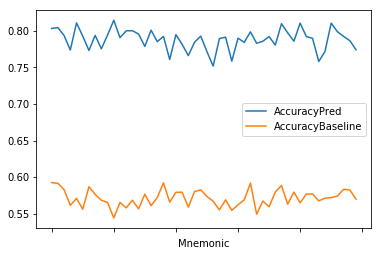

In [35]:
perf = plot_accuracy_by('Mnemonic', test_predictions)

In [36]:
perf.sort_values(by='AccuracyPred', ascending=False).head(20)

,AccuracyPred,AccuracyBaseline,AccPred - AccBaseline
Mnemonic,,,
CON,0.814683,0.544109,0.270574
BAS,0.811065,0.570924,0.240141
SIE,0.810763,0.564755,0.246008
VNA,0.810731,0.571934,0.238797
RWE,0.809917,0.588548,0.221370
ADS,0.804618,0.591474,0.213144
1COV,0.803458,0.592507,0.210951
DTE,0.801063,0.560803,0.240260
DBK,0.800353,0.568316,0.232038


In [37]:
perf.sort_values(by='AccuracyPred', ascending=False).tail(20)

,AccuracyPred,AccuracyBaseline,AccPred - AccBaseline
Mnemonic,,,
SDF,0.786001,0.579461,0.206540
OSR,0.785919,0.567258,0.218661
DWNI,0.785388,0.571918,0.213470
HEI,0.784534,0.580283,0.204250
LXS,0.784404,0.568807,0.215596
MUV2,0.783175,0.549171,0.234005
FRE,0.781657,0.579290,0.202367
PSM,0.780702,0.579532,0.201170
DPW,0.778829,0.576582,0.202247


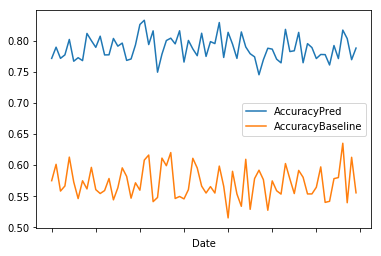

In [38]:
perf = plot_accuracy_by('Date', test_predictions)

In [39]:
perf.sort_values(by='AccuracyPred', ascending=False).head(20)

,AccuracyPred,AccuracyBaseline,AccPred - AccBaseline
Date,,,
2018-02-08,0.832937,0.608076,0.224861
2018-03-05,0.829249,0.598419,0.230830
2018-02-07,0.826087,0.559684,0.266403
2018-03-26,0.818263,0.602507,0.215756
2018-04-25,0.817117,0.635135,0.181982
2018-02-20,0.816019,0.549564,0.266455
2018-02-12,0.815873,0.541270,0.274603
2018-03-12,0.814138,0.533757,0.280381
2018-03-07,0.813492,0.515079,0.298413


In [40]:
perf.sort_values(by='AccuracyPred', ascending=False).tail(20)

,AccuracyPred,AccuracyBaseline,AccPred - AccBaseline
Date,,,
2018-03-06,0.773123,0.566008,0.207115
2018-01-18,0.772691,0.546172,0.226519
2018-01-12,0.771654,0.558268,0.213386
2018-01-10,0.771610,0.574941,0.196669
2018-03-09,0.771610,0.553529,0.218081
2018-04-17,0.771377,0.564356,0.207021
2018-04-24,0.771300,0.579970,0.191330
2018-02-05,0.770635,0.546825,0.223810
2018-03-22,0.770324,0.558800,0.211523
